<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 2: deep learning для обработки звука</center></h2>

# Введение

В этом задании Вы поработаете и разберетесь в деталях с форматами представления аудиоданных в задачах глубинного обучения, а так же напишете несколько моделей для классификации аудиозаписей.

В процессе выполнения Вы познакомитесь:
* С алгоритмом построения Мел-спектрограммы
* Рекуррентными и сверточными классификаторами аудиоданных
* Алгоритмом аугментации аудиоданных SpecAugment

In [ ]:
!pip install torch==1.8.0 torchaudio==0.8.0 numpy==1.20.0

ERROR: Could not find a version that satisfies the requirement torch==1.8.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2)
ERROR: No matching distribution found for torch==1.8.0


In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torchaudio
from IPython import display
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm

%matplotlib inline

# assert torch.__version__.startswith("1.8.0")
print(torchaudio.__version__) # == "0.8.0"

device = "cuda:0"

2.2.1+cu121


In [ ]:
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)


# Классификация аудиозаписей.

В этом домашнем задании Вам предстоит классифицировать аудиозаписи из датасета [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html).

Данный датасет состоит из 8732 записей, разбитых на train/val/test датасеты.

![image](https://paperswithcode.com/media/datasets/UrbanSound8K-0000003722-02faef06.jpg)

Каждая аудиозапись содержит запись шума города и принадлежит одному из 10 классов:

`[air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music]`


## Задание 1 (1 балл). Знакомство с данными.

- Скачайте датасет из [Google Drive](https://drive.google.com/drive/folders/1Q1mgopM_aQToKdSRlTI9zFW83sOqvrCS?usp=sharing) c и распакуйте в папку `./data`.
- Положите разархивированные данные рядом с юпитерской тетрадкой. Если вы работаете в колабе, залейте данные на свой гугл-диск и воспользуйтесь кодом ниже для синхронизации тетрадки с ним (это поможет не подгружать их по 10 раз).

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# /content/drive/MyDrive/HW2_dataset.zip

- Напишите `AudioDataset` класс, который будет принимать путь к файлам `train_part.csv` и `val_part.csv` и возращать тройки объектов `(x, y, len)`, где `x` - аудиозапись, `y` - класс аудиозаписи, `len` - длина аудиозаписи. Аудиозаписи **не должны постоянно храниться в RAM**, подгрузку _wav_ файлов надо сделать при запросе через `__getitem__` метод. Кроме того, надо сделать паддинг аудиозаписи - если она короче чем `pad_size` параметр, надо дополнять ее нулями.

- С помощью функции `display.Audio` проиграйте в ноутбуке пару аудиозаписей.

In [ ]:
# path

In [ ]:
# скачаем и распакуем данные
!rm -r ./data
!mkdir ./data/
!pip install gdown
# !cd ./data && gdown --id '1057RRnXefWOCvpzjSnRA-Xl-O3NnX8Vq' && unzip HW2_dataset
!cd ./data && gdown --id '/content/drive/MyDrive/HW2_dataset.zip' && unzip HW2_dataset

rm: cannot remove './data': No such file or directory
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=/content/drive/MyDrive/HW2_dataset.zip

but Gdown can't. Please check connections and permissions.


In [ ]:
!unzip /content/drive/MyDrive/HW2_dataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: urbansound8k/data/712.wav  
  inflating: urbansound8k/data/1286.wav  
  inflating: urbansound8k/data/7768.wav  
  inflating: urbansound8k/data/855.wav  
  inflating: urbansound8k/data/1319.wav  
  inflating: urbansound8k/data/15.wav  
  inflating: urbansound8k/data/2610.wav  
  inflating: urbansound8k/data/3268.wav  
  inflating: urbansound8k/data/5619.wav  
  inflating: urbansound8k/data/6310.wav  
  inflating: urbansound8k/data/6304.wav  
  inflating: urbansound8k/data/4513.wav  
  inflating: urbansound8k/data/2162.wav  
  inflating: urbansound8k/data/2604.wav  
  inflating: urbansound8k/data/841.wav  
  inflating: urbansound8k/data/699.wav  
  inflating: urbansound8k/data/6462.wav  
  inflating: urbansound8k/data/869.wav  
  inflating: urbansound8k/data/8467.wav  
  inflating: urbansound8k/data/7754.wav  
  inflating: urbansound8k/data/7032.wav  
  inflating: urbansound8k/data/3254.wav  
  inflating: ur

In [ ]:
# классы данных
classes = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music",
]

In [ ]:
x = torch.Tensor([1, 2, 3])
y = torch.Tensor([5, 6])
x, y
torch.cat((x, y), 0)

tensor([1., 2., 3., 5., 6.])

In [ ]:
class AudioDataset(Dataset):
    def __init__(
        self,
        path_to_csv: str,
        path_to_folder: str,
        pad_size: int = 384000,
        sr: int = 44100,
    ):
        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)[["ID", "Class"]]
        self.path_to_folder = path_to_folder
        self.pad_size = pad_size

        self.sr = sr

        self.class_to_idx = {classes[i]: i for i in range(10)}

    def __getitem__(self, index: int):

        # достаю из self.csv id и класс
        # достаю из файла аудио по id
        # дополняю аудио нулями
        # соединяю аудио, класс и его длину


        # id, label = self.csv[self.csv['ID'] == index].iloc[0]
        id, label = self.csv.iloc[index]

        audio_path = self.path_to_folder + '/' + str(id) + '.wav'
        x, sr = torchaudio.load(audio_path)
        lena = x.shape[1]
        y = self.class_to_idx[label]

        if x.size(1) < self.pad_size:
          x_zeros =  torch.zeros(self.pad_size - lena)
          x = torch.cat((x[0], x_zeros), 0)
        else:
          x = x[0]

          # x_zeros = torch.zeros((1, 1, self.pad_size - lena))
          # x = torch.cat((x, x_zeros), 2)


        dic = {'x': x, 'y' : y, 'len' : lena}

        return dic



    def __len__(self):
        return self.csv.shape[0]

In [ ]:
# создадим датасеты
train_dataset = AudioDataset(
    "./urbansound8k/train_part.csv", "./urbansound8k/data"
)
val_dataset = AudioDataset(
    "./urbansound8k/val_part.csv", "./urbansound8k/data"
)

In [ ]:
# проверим размеры датасетов
assert len(train_dataset) == 4500
assert len(val_dataset) == 935

In [ ]:
#  pd.read_csv("./data/urbansound8k/val_part.csv").iloc[403]

In [ ]:
# проверим возращаемые значения __getitem__
item = train_dataset.__getitem__(0)

assert item["x"].shape == (384000,)
assert item["y"] == 0
assert item["len"] == 176400

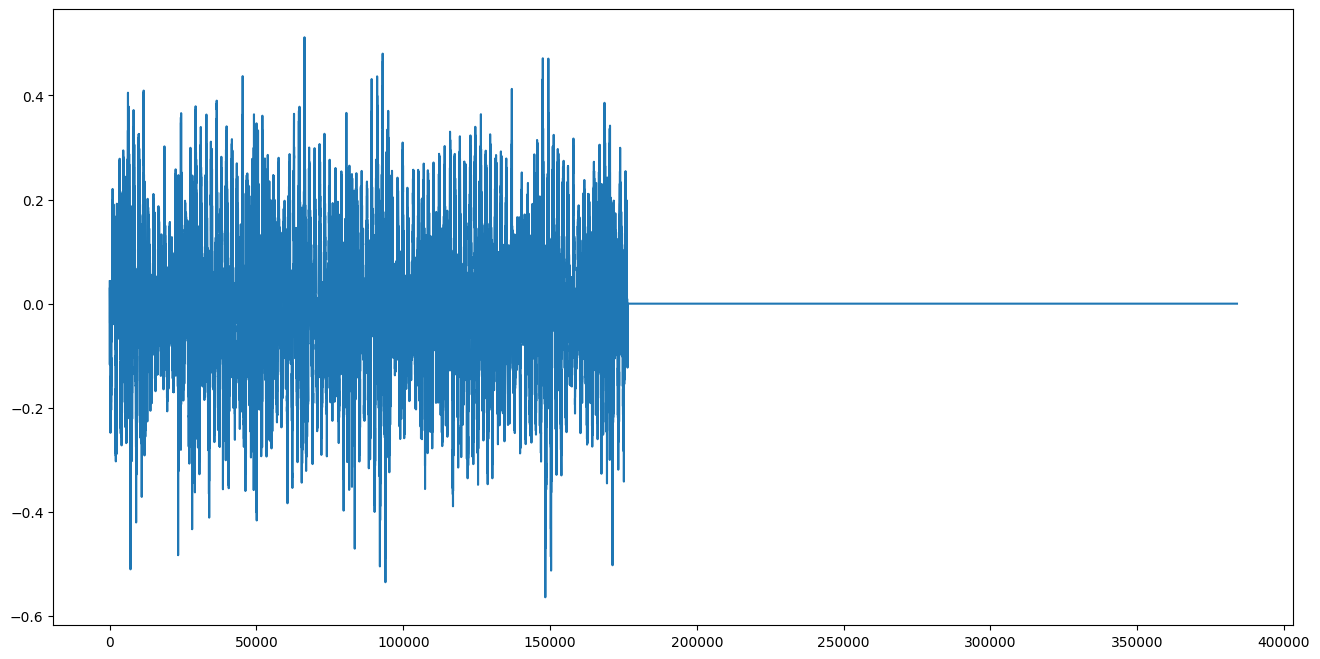

In [ ]:
# нарисуем и проиграем аудиозаписить
item = train_dataset.__getitem__(0)
plt.figure(figsize=(16, 8))
plt.plot(item["x"])

display.Audio(item["x"], rate=train_dataset.sr)

In [ ]:
# # нарисуем и проиграем аудиозаписить
# item = val_dataset.__getitem__(4775)

# display.Audio(item["x"], rate=train_dataset.sr)

In [ ]:
a, b = train_dataset.csv[train_dataset.csv['ID'] == 4775].iloc[0]
# a, b = train_dataset.csv.iloc[4775]
a, b

(4775, 'children_playing')

In [ ]:
# создадим даталоадеры
train_dataloader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, pin_memory=True, drop_last=True
)
val_dataloader = DataLoader(val_dataset, batch_size=32, pin_memory=True)

In [ ]:
a = 0
for batch in train_dataloader:
  print(batch["x"].shape, batch["y"].shape, batch["len"].shape)
  a += 1
  if a > 10:
    break

torch.Size([32, 384000]) torch.Size([32]) torch.Size([32])
torch.Size([32, 384000]) torch.Size([32]) torch.Size([32])
torch.Size([32, 384000]) torch.Size([32]) torch.Size([32])
torch.Size([32, 384000]) torch.Size([32]) torch.Size([32])
torch.Size([32, 384000]) torch.Size([32]) torch.Size([32])
torch.Size([32, 384000]) torch.Size([32]) torch.Size([32])
torch.Size([32, 384000]) torch.Size([32]) torch.Size([32])
torch.Size([32, 384000]) torch.Size([32]) torch.Size([32])
torch.Size([32, 384000]) torch.Size([32]) torch.Size([32])
torch.Size([32, 384000]) torch.Size([32]) torch.Size([32])
torch.Size([32, 384000]) torch.Size([32]) torch.Size([32])


In [ ]:
for batch in train_dataloader:
  print(batch["x"], batch["y"], batch["len"])
  break

tensor([[ 3.6621e-03,  3.8452e-03,  4.0283e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-7.8125e-02,  4.6875e-02,  1.2500e-01,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.1035e-05,  6.1035e-05,  9.1553e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-3.0518e-05, -3.0518e-05, -3.0518e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.0925e-02, -3.1738e-03,  5.9204e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.2088e-01, -9.8480e-02, -7.3334e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]]) tensor([3, 8, 4, 8, 5, 7, 1, 0, 9, 5, 5, 9, 3, 9, 3, 0, 2, 7, 8, 3, 4, 0, 7, 7,
        4, 0, 2, 4, 0, 6, 8, 8]) tensor([ 39037,  44100,  43659, 176400, 176400, 176400,  64000, 176400, 384000,
        192000, 384000, 176400, 176400, 176400, 192000, 176400, 192000, 176400,
        176400, 176400,  23373, 192000, 176400, 384000, 176400, 176400, 176400,
         33338,

## Задание 2. Рекуррентная сеть для классификации аудиозаписей по сырому сигналу (2 балла)

По своей сути аудиозапись является ни чем иным, как временным рядом - замеры микрофона делаются через равные промежутки времени и хранятся в виде последовательности.

Как известно, рекуррентные сети отлично подходят для работы с различными последовательностями, в том числе и с временными рядами.

Обучим простую реккурентную сеть для классификации аудиозаписей.

1. Разбейте аудизаписить на окошки размером `1024` с шагом `256`. Для этих целей отлично подойдет метод `torch.Tensor.unfold`.
1. Применим к каждому получившемуся окну аудиосигнала полносвязную сеть с активациями `ReLU` и  внутренними размерностям `(1024 -> 256 -> 64 -> 16)`.
2. По получившимся последовательностям пройдемся двунаправленой (`bidirectional=True`) LSTM с двумя слоями (`layers=2`).
3. Склеим c помощью `torch.cat` последние `hidden_state` для каждого слоя и применим к ним полносвязную сеть `(2 * hidden_size * num_layers -> 256 -> 10)` с активацией `ReLU`.

<center>
<img src="https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2020-2023/2022/hw/hw2/imgs/rnn_raw.png" height="500">
</center>

*Совет*: для убыстрения обучения имеет смысл в полносвязные сети добавить `BatchNorm`.

In [ ]:
class RecurrentRawAudioClassifier(nn.Module):
    def __init__(
        self,
        num_classes=10,
        window_length=1024,
        hop_length=256,
        hidden=256,
        num_layers=2,
    ) -> None:
        super().__init__()

        self.window_length = window_length
        self.hop_length = hop_length

        self.first_mlp = nn.Sequential(
          nn.Linear(1024,256),
          nn.BatchNorm1d(1497),
          nn.ReLU(),
          nn.Linear(256, 64),
          nn.BatchNorm1d(1497),
          nn.ReLU(),
          nn.Linear(64, 16)
        )

        self.rnn = nn.LSTM(input_size=16, hidden_size=hidden, num_layers=num_layers, bidirectional=True)

        self.final_mlp = nn.Sequential(
          # nn.Linear(2 * hidden * num_layers,256),
          nn.Linear(hidden * num_layers,256), # так заработало
          nn.BatchNorm1d(256),
          nn.ReLU(),
          nn.Linear(256, 10)
        )

    def forward(self, x, lens) -> torch.Tensor:
        # разбейте сигнал на окна
        # batch_windows.shape == (B, NUM WINDOWS, 1024)
        batch_windows = x.unfold(1, self.window_length, self.hop_length)



        # примените к каждому окну полносвязную сеть
        batch_windows_feautures = self.first_mlp(batch_windows)

        # примените к получившемся последовательностям LSTM и возьмите hidden state
        rnn_out, _ = self.rnn(batch_windows_feautures)

        # склейте hidden_state по слоям
        hidden_flattened = rnn_out[:, -1, :].reshape(rnn_out.size(0), -1)

        # примените полносвязную сеть и получим логиты классов
        return self.final_mlp(hidden_flattened)

Обучим получившуюся модель.

In [ ]:
def train_audio_clfr(
    model,
    optimizer,
    train_dataloader,
    sr,
    criterion=torch.nn.CrossEntropyLoss(),
    data_transform=None,
    augmentation=None,
    num_epochs=10,
    device="cuda:0",
    verbose_num_iters=10,
):
    model.train()
    iter_i = 0

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        print(epoch)
        for batch in tqdm(train_dataloader):
            x = batch["x"].to(device)
            y = batch["y"].to(device)
            lens = batch["len"].to(device)

            # применяем преобразование входных данных
            if data_transform:
                x, lens = data_transform(x, lens, device=device, sr=sr)

            # примеменяем к логмелспектрограмме аугментацию
            if augmentation:
                x, lens = augmentation(x, lens)

            x, lens = x.to(device), lens.to(device)
            probs = model(x, lens)
            optimizer.zero_grad()
            loss = criterion(probs, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            # считаем точность предсказания
            pred_cls = probs.argmax(dim=-1)
            train_accuracies.append((pred_cls == y).float().mean().item())

            iter_i += 1

            # раз в verbose_num_iters визуализируем наши лоссы и семплы
            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)

                print(f"Epoch {epoch}")

                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.xlabel("Iteration")
                plt.ylabel("Train loss")
                plt.plot(np.arange(iter_i), train_losses)

                plt.subplot(1, 2, 2)
                plt.xlabel("Iteration")
                plt.ylabel("Train acc")
                plt.plot(np.arange(iter_i), train_accuracies)

                plt.show()

    model.eval()



In [ ]:
# создадим объекты модели и оптимизатор
rnn_raw = RecurrentRawAudioClassifier()
rnn_raw.to(device)
optim = torch.optim.Adam(rnn_raw.parameters(), lr=3e-4)

Epoch 9


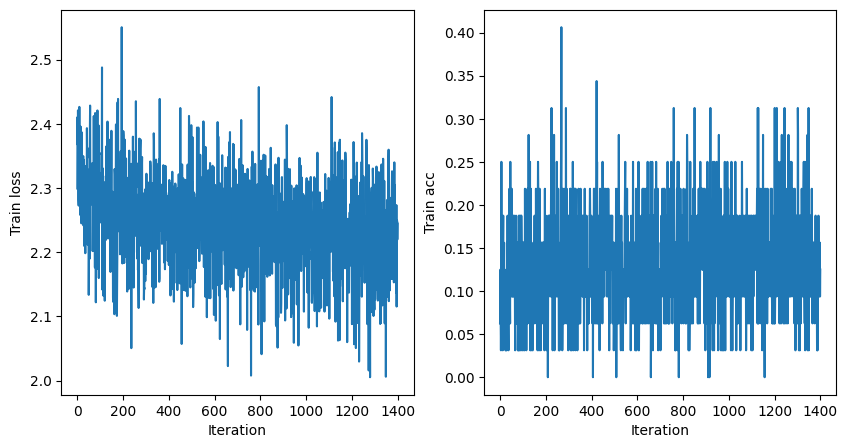

100%|██████████| 140/140 [01:33<00:00,  1.49it/s]


In [ ]:
# обучим модель
train_audio_clfr(rnn_raw, optim, train_dataloader, train_dataset.sr)

Посчитаем метрики на валидационном датасете.

In [ ]:
def plot_confusion_matrix(model, val_dataloader, sr, device, data_transform=None):
    pred_true_pairs = []
    for batch in val_dataloader:
        x = batch["x"].to(device)
        y = batch["y"].to(device)
        lens = batch["len"].to(device)

        with torch.no_grad():
            if data_transform:
                x, lens = data_transform(x, lens, sr=sr, device=device)

            probs = model(x, lens)

            pred_cls = probs.argmax(dim=-1)

        for pred, true in zip(pred_cls.cpu().detach().numpy(), y.cpu().numpy()):
            pred_true_pairs.append((pred, true))

    print(f"Val accuracy: {np.mean([p[0] == p[1] for p in pred_true_pairs])}")

    cm_df = pd.DataFrame(
        confusion_matrix(
            [p[1] for p in pred_true_pairs],
            [p[0] for p in pred_true_pairs],
            normalize="true",
        ),
        columns=classes,
        index=classes,
    )
    sn.heatmap(cm_df, annot=True)

Val accuracy: 0.14308035714285713


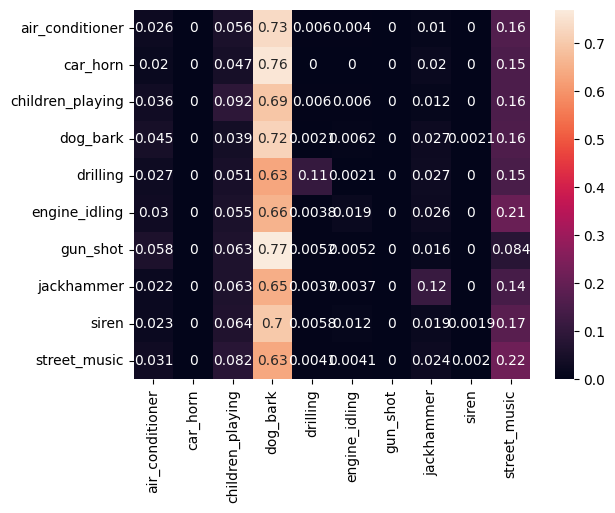

In [ ]:
plot_confusion_matrix(rnn_raw, train_dataloader, train_dataset.sr, device)

Val accuracy: 0.1144385026737968


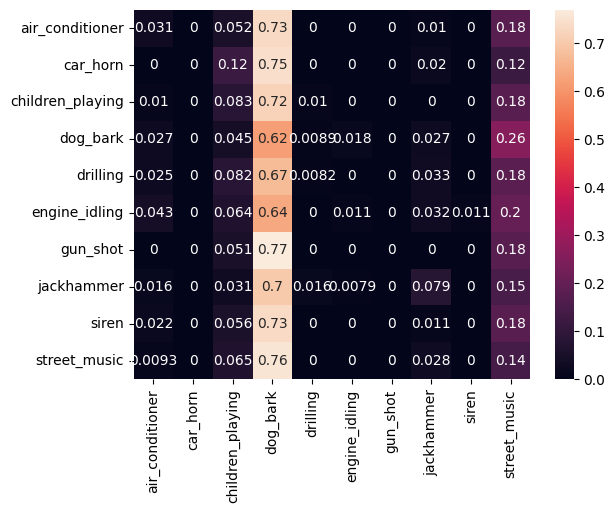

In [ ]:
plot_confusion_matrix(rnn_raw, val_dataloader, train_dataset.sr, device)

*Вопрос* : Сильно ли отличается качество модели на тренировочной и валидационной выборке? Если да, то как думаете, в чем причина?

In [ ]:
# При первом прогоне результаты были другими, но интуциия не меняется -
# дело в балансе классов и в том, что доли в трейне и вале не совпадают

In [ ]:
# На трейне лучше,нейросетка научилась круто отличать детей и
# более-менее неплохо разбираться с сиренами и кондиционерами

In [ ]:
tr = pd.read_csv('./urbansound8k/train_part.csv')[["ID", "Class"]]
va = pd.read_csv("./urbansound8k/val_part.csv")[["ID", "Class"]]
tr.groupby('Class').count()


,ID
Class,
air_conditioner,503
car_horn,255
children_playing,504
dog_bark,488
drilling,478
engine_idling,530
gun_shot,191
jackhammer,541
siren,517


In [ ]:
va.groupby('Class').count()

,ID
Class,
air_conditioner,97
car_horn,51
children_playing,96
dog_bark,112
drilling,122
engine_idling,94
gun_shot,39
jackhammer,127
siren,90


In [ ]:
# Неудивительно - это три самые частые категории в трейне
# Причем в валидационной выборке они встречаются реже - поэтому и качество на ней меньше

## Задание 3. Построение Мел-cпектрограмм. (2 балла)

Сырой сигнал очень чувствителен ко многим факторам - увеличение/уменьшение громкости, внешние шумы, сменение тембра говорящего очень резко меняют сырой сигнал. Это влияет и на качество глубоких сетей, обученных на сыром аудиосигнале.

Для построения надежных и устойчивых к переобучению моделей используют другое представление аудиоданных - спектрограммы, в том числе Мел-спектрограмму.

Идея её построения заключается в следующем:
1. Сигнал разбивается на временные интервалы (с пересечениями)
2. К каждому временному интервалу применяется фильтр (как правило косинусоидальный)
3. К профильтрованному сигналу применяется дискретное преобразование Фурье и вычисляются спектральные признаки сигнала.
4. Спектральные признаки с помощью логарифмического преобразования приводятся в Мел-шкалу.

<center>
<img src="https://antkillerfarm.github.io/images/img2/Spectrogram_5.png" height="550">
</center>

В этом задании мы сами шаг за шагом напишем алгоритм построения мелспектрограммы и сравнимся с референсной функцией из `torchaudio`.

In [ ]:
from torchaudio.transforms import MelSpectrogram


# референсная функция
def compute_log_melspectrogram_reference(wav_batch, lens, sr, device='cpu'):
    featurizer = MelSpectrogram(
        sample_rate=sr,
        n_fft=1024,
        win_length=1024,
        hop_length=256,
        n_mels=64,
        center=False,
    ).to(device)

    return torch.log(featurizer(wav_batch).clamp(1e-5)), lens // 256

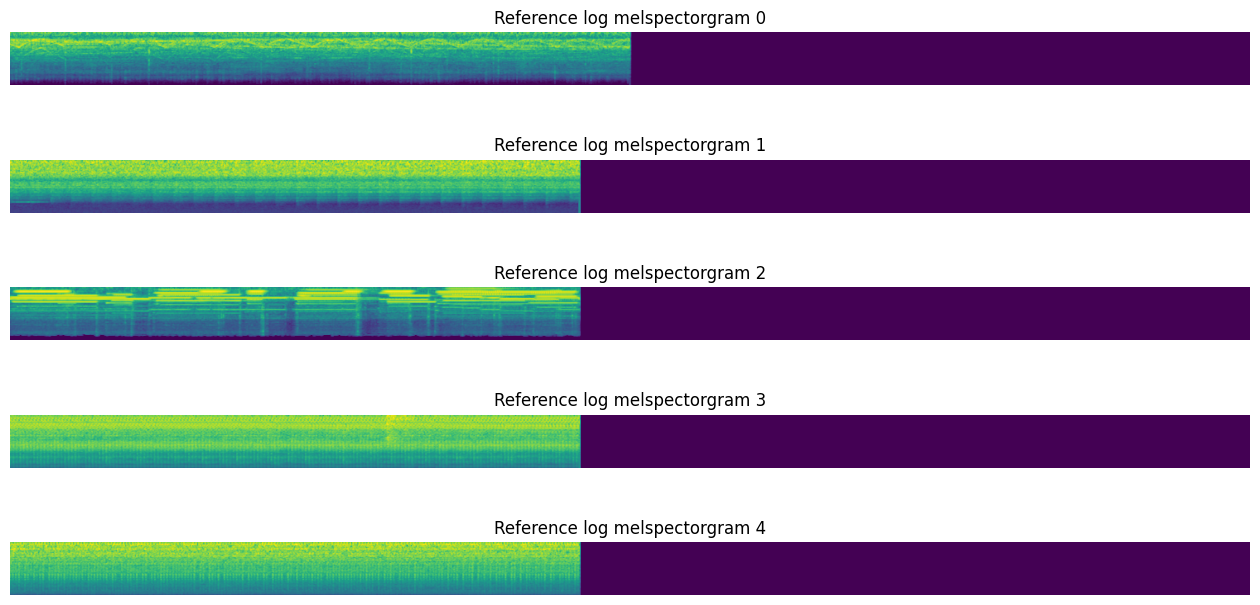

In [ ]:
# возьмем случайный батч
for batch in train_dataloader:
    break

wav_batch = batch["x"]
lens = batch["len"]

# посчитаем лог мелспектрограммы
log_melspect, lens = compute_log_melspectrogram_reference(
    wav_batch, lens, train_dataset.sr
)

# нарисуем получившиеся референсные значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Reference log melspectorgram {i}")
    axes[i].imshow(log_melspect[i].numpy())

Теперь сделаем то же самое сами.

In [ ]:
sr = train_dataset.sr
n_fft = 1024
win_length = 1024
hop_length = 256
n_mels = 64


Для начала с помощью метода `unfold` разделим аудиосигнал на окна размера `win_lenght` через промежутки `hop_lenght`.

In [ ]:
wav_batch

tensor([[-0.0234, -0.0246, -0.0257,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0756,  0.0701,  0.0663,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1472,  0.1511,  0.1540,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0767, -0.0729, -0.0633,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0600, -0.0353, -0.0168,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0716, -0.0582, -0.0428,  ...,  0.0000,  0.0000,  0.0000]])

In [ ]:
windows = wav_batch.unfold(1, win_length, hop_length)
assert windows.shape == (32, 1497, 1024)

Нарисуем и проиграем сигнал из одного окна.

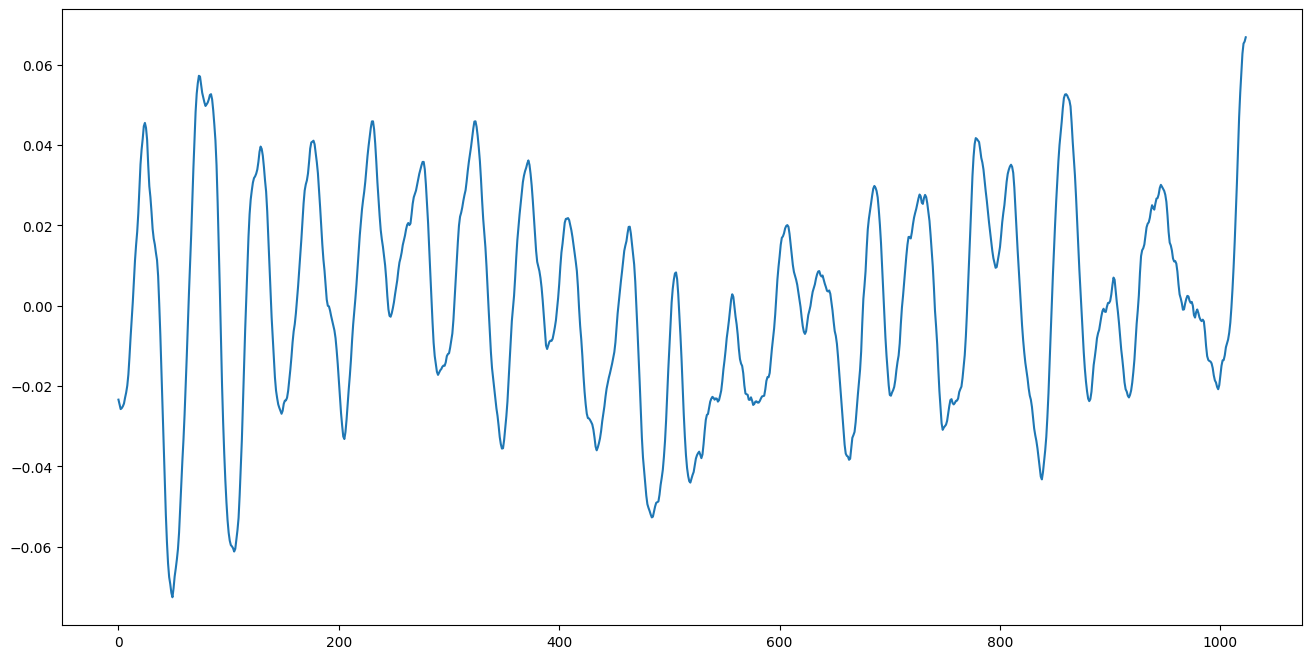

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(windows[0, 0])

display.Audio(windows[0, 0], rate=train_dataset.sr)

Теперь нам надо применить косинуисальный фильтр к сигналу из окна. Для этого с помощью `torch.hann_window` создадим косинусоидальный фильтр и умножим его поэлементно на все окна.

In [ ]:
filter = torch.hann_window(win_length)
windows_with_applied_filter = windows * filter[None, None, :]


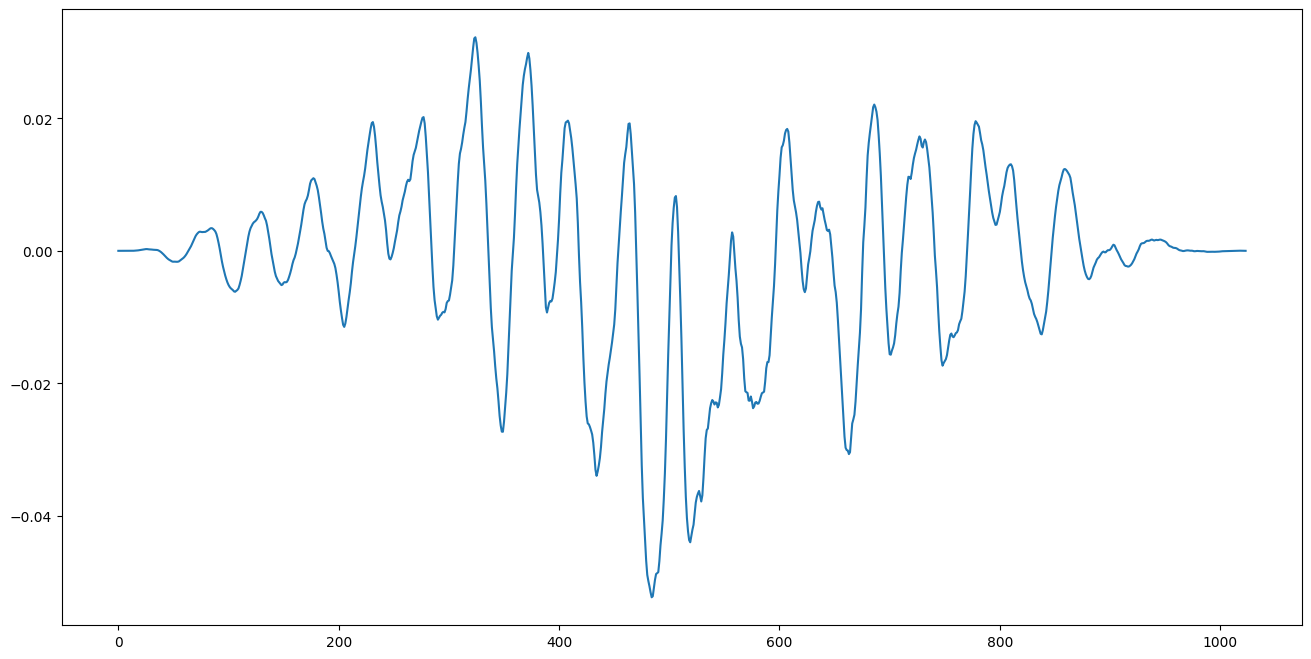

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(windows_with_applied_filter[0, 0])

display.Audio(windows_with_applied_filter[0, 0], rate=train_dataset.sr)

С помощью `torch.fft.fft` примените дискретное преобразование фурье к каждому окну и возьмите первые `n_fft // 2 + 1` компоненты.

Дальше с помощью возведения элементов тензора в квадрат и `torch.abs()` получите магнитуды.

In [ ]:
fft_features = torch.fft.fft(windows_with_applied_filter)
fft_features = fft_features[:, :, :n_fft // 2 + 1]
fft_magnitudes = torch.abs(fft_features**2)
print(fft_magnitudes.shape)
assert fft_magnitudes.shape == (32, 1497, 513)




torch.Size([32, 1497, 513])


Через `torchaudio.transforms.MelScale` создайте класс для перевода магнитуд в Мел-шкалу.

In [ ]:
melscale = torchaudio.transforms.MelScale(
    n_mels=n_mels,
    sample_rate=sr,
    n_stft=n_fft // 2 + 1
)
melscale







MelScale()

In [ ]:
melscale.fb

tensor([[-0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.8879, 0.1121, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8370, 0.1630,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0726],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0363],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [ ]:
melscale.fb.shape

torch.Size([513, 64])

Нелинейное преобразование для перевода в Мел-шкалу выглядит следующим образом.

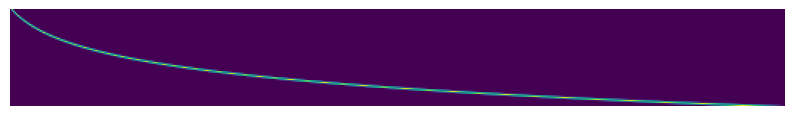

In [ ]:
plt.figure(figsize=(10, 5))
plt.axis("off")
plt.imshow(melscale.fb.numpy().transpose())

Примените Мел-шкалу к магнитудам.

In [ ]:
n_mels, sr, n_fft // 2 + 1


(64, 44100, 513)

In [ ]:
print(fft_magnitudes.shape)
fft_magnitudes.transpose(-1, -2).shape

torch.Size([32, 1497, 513])


torch.Size([32, 513, 1497])

In [ ]:
mel_spectrogram =  melscale(fft_magnitudes.transpose(-1, -2))
print(mel_spectrogram.shape)
assert mel_spectrogram.shape == (32, 64, 1497)

torch.Size([32, 64, 1497])


Сделайте обрезку значений по `1e-5` и примените `torch.log` для получения логарифмированной Мел-спектрограммы.

In [ ]:
logmel_spectrogram = torch.log(mel_spectrogram.clamp(1e-5))
assert logmel_spectrogram.shape == (32, 64, 1497)

Полученные логарифмированные Мел-Спектрограммы должны совпадать с референсными.

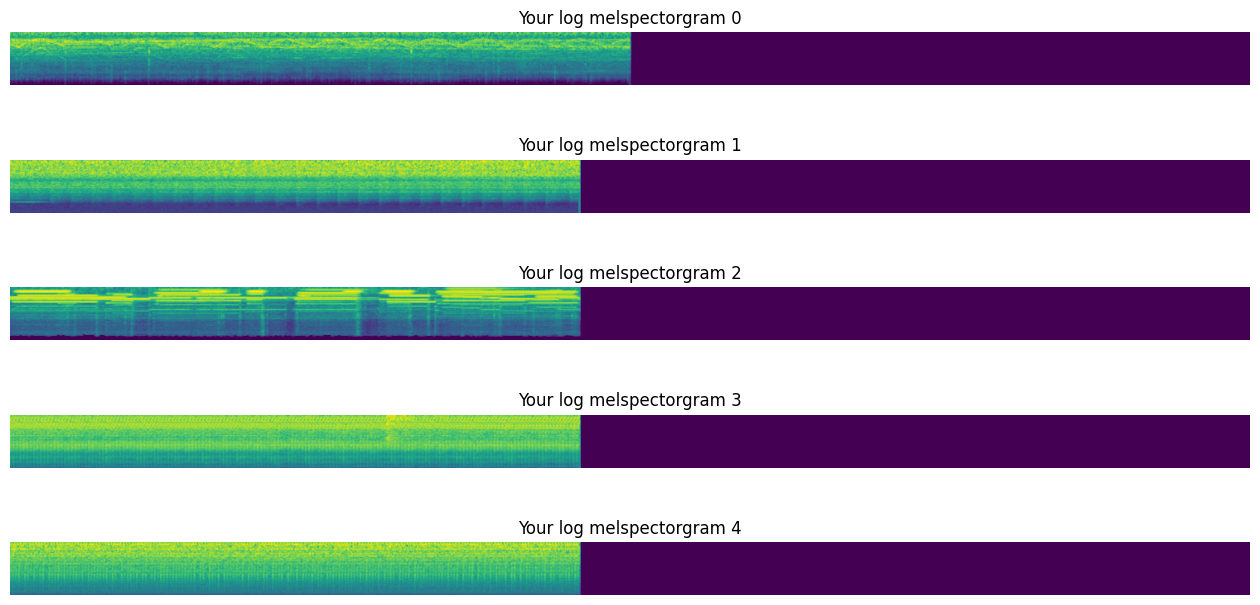

In [ ]:
# нарисуем получившиеся значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Your log melspectorgram {i}")
    axes[i].imshow(logmel_spectrogram[i].numpy())

Теперь оформим эту логику в функцию.

In [ ]:
# ваша реализация

sr = train_dataset.sr
n_fft = 1024
win_length = 1024
hop_length = 256
n_mels = 64

def compute_log_melspectrogram(wav_batch, lens, sr, device="cuda:0"):

  wav_batch = wav_batch.to('cpu')
  windows = wav_batch.unfold(1, win_length, hop_length)
  filter = torch.hann_window(win_length)
  windows_with_applied_filter = windows * filter[None, None, :]

  fft_features = torch.fft.fft(windows_with_applied_filter)
  fft_features = fft_features[:, :, :n_fft // 2 + 1]
  fft_magnitudes = torch.abs(fft_features**2)

  melscale = torchaudio.transforms.MelScale(
    n_mels=n_mels,
    sample_rate=sr,
    n_stft=n_fft // 2 + 1
  )

  mel_spectrogram =  melscale(fft_magnitudes.transpose(-1, -2))


  logmel_spectrogram = torch.log(mel_spectrogram.clamp(1e-5))

  return logmel_spectrogram.to(device), lens


Финальная проверка.

In [ ]:
assert torch.allclose(
    compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)[0],
    compute_log_melspectrogram(wav_batch, lens, train_dataset.sr)[0].to('cpu'), # здесь убрал [0]
    atol=1e-5,
)

In [ ]:
compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)[0].to(device).shape

torch.Size([32, 64, 1497])

In [ ]:
compute_log_melspectrogram(wav_batch, lens, train_dataset.sr).shape

AttributeError: 'tuple' object has no attribute 'shape'

## Задание 4. Рекуррентная сеть для классификации аудиозаписей по логарифмированным Мел-спектрограммам (1 балл)

Измените реализацию рекуррентной сети из задания 2, таким образом, чтобы она вместо сырого сигнала смогла принимать логарифмированные Мел-спетрограммы:
1. Уберите шаги 1-2
2. Сделайте вход LSTM равным 64

<center>
<img src="https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2020-2023/2022/hw/hw2/imgs/rnn_mel.png" height="500">
</center>

**За реализацию архитектуры дается 0.5 балла.**

In [ ]:
class RecurrentMelSpectClassifier(nn.Module):
    def __init__(
        self,
        num_classes=10,
        window_length=1024,
        hop_length=256,
        hidden=256,
        num_layers=2,
    ) -> None:
        super().__init__()

        self.window_length = window_length
        self.hop_length = hop_length

        self.rnn = nn.LSTM(input_size=64, hidden_size=hidden, num_layers=num_layers, bidirectional=True)

        self.final_mlp = nn.Sequential(
          # nn.Linear(2 * hidden * num_layers,256),
          nn.Linear(hidden * num_layers,256), # так заработало
          nn.BatchNorm1d(256),
          nn.ReLU(),
          nn.Linear(256, 10)
        )

    def forward(self, x, lens) -> torch.Tensor:


        # примените к получившемся последовательностям LSTM и возьмите hidden state
        print(x.shape)
        rnn_out, _ = self.rnn(x.transpose(-1, -2))

        # склейте hidden_state по слоям
        hidden_flattened = rnn_out[:, -1, :].reshape(rnn_out.size(0), -1)

        # примените полносвязную сеть и получим логиты классов
        return self.final_mlp(hidden_flattened)

In [ ]:
rnn_mel = RecurrentMelSpectClassifier()
rnn_mel.to(device)

optim = torch.optim.Adam(rnn_mel.parameters(), lr=3e-4)

Epoch 9


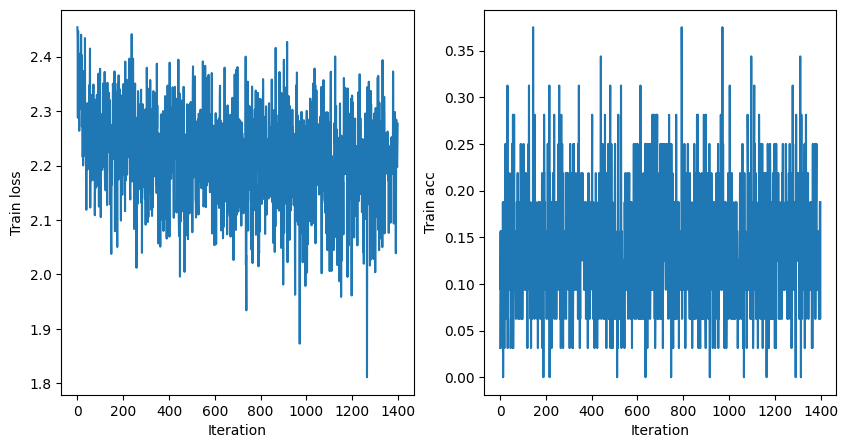

100%|██████████| 140/140 [04:08<00:00,  1.77s/it]


In [ ]:
train_audio_clfr(
    rnn_mel.to(device),
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
)


# torch.Size([32, 1497, 16])

Посчитаем метрики на валидационном датасете.

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.8 на валидационном датасете.**

torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([32, 64, 1497])
torch.Size([7, 64, 1497])
Val accuracy: 0.14010695187165775


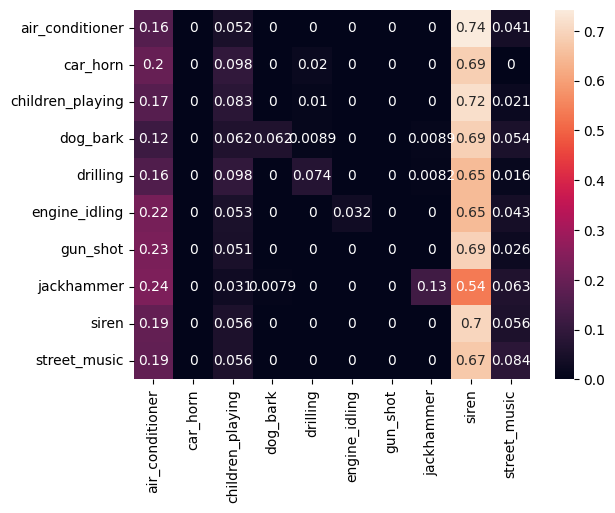

In [ ]:
plot_confusion_matrix(
    rnn_mel,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)

## Задание 5. Cверточная сеть для классификации аудиозаписей по мелспектрограммам. (2 балла)

Легко заметить, что мелспектрограммы имеют четко выраженные паттерны - если приноровиться, то даже человек, посмотрев на мелспектрограмму, сможет _визуально_ проклассифицировать объект.

Это позволяет свести задачу классификации аудиозаписей к задаче классификации картинок.

Реализуем такую сверточную сеть:

* 2x (Conv2d 3x3 @ 16, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 32, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 64, BatchNorm2d, ReLU)
* MaxPoll 2x2
* (Conv2d 3x3 @ 128, BatchNorm2d, ReLU)
* (Conv2d 2x2 @ 128, BatchNorm2d, ReLU)
* Global MaxPoll
* Fully Connected 128, ReLU
* Fully Connected 10

Совет: подобная архитектура была реализована в [**PANNs: Large-Scale Pretrained Audio Neural Networks for Audio Pattern Recognition**](https://arxiv.org/pdf/1912.10211.pdf), можете использовать эту статью как референс.


**За реализацию архитектуры дается 1.5 балла.**

In [ ]:
class CNN10(nn.Module):
    def __init__(self, num_classes=10, hidden=16):
        super().__init__()

        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.final_mlp = nn.Sequential(
            # nn.AdaptiveMaxPool2d((1, 1)),
            # nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )


    def forward(self, x, lens):
        z = self.cnn_backbone(x[:, None, :, :])
        z = torch.nn.functional.max_pool2d(z, kernel_size=z.size()[2:])[:, :, 0, 0]
        return self.final_mlp(z)


In [ ]:
cnn = CNN10()
cnn.to(device)

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 4


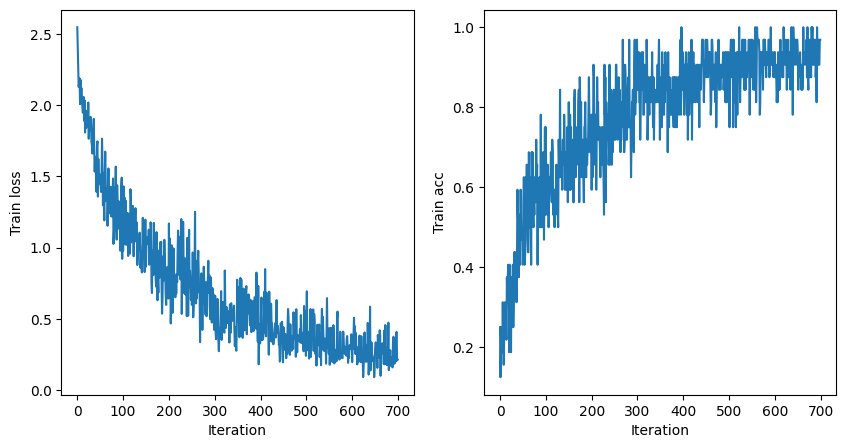

100%|██████████| 140/140 [03:50<00:00,  1.64s/it]


In [ ]:
train_audio_clfr(
    cnn,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
    num_epochs=5,
)

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.85 на валидационном датасете.**

Val accuracy: 0.8524064171122995


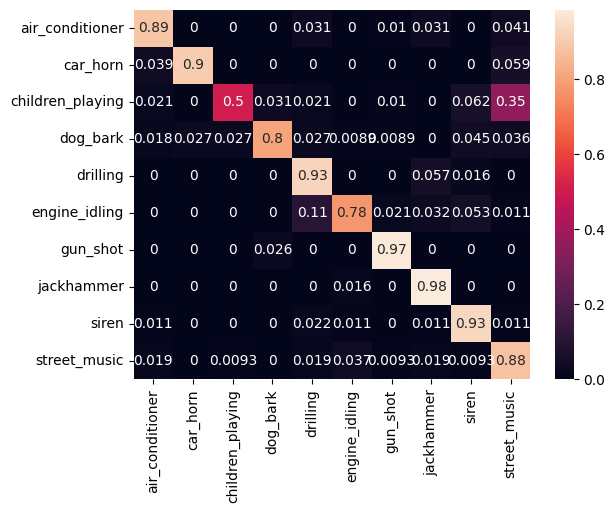

In [ ]:
plot_confusion_matrix(
    cnn,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)

In [ ]:
# ура !!!!

## Задание 6. Аугментация SpecAugment (2 балла)

Обычно датасеты с аудиозаписями довольно малы. Наш датасет тому пример - всего 4500 объектов в обучающей выборке. Обучение глубокий сетей с большим кол-вом параметров на таких датасетах часто ведет к переобучению и проседанию метрик на валидационном и тестовом датасетах.

Для борьбы с переобучением имеет смысл использовать аугментацию данных. Для мелспектрограмм была придумана аугментация под названием SpecAugment.

Смысл её очень прост - зануление спектрограммы по временным промежуткам и по мел-частотам:
1. Выбираются несколько временных промежутков ${[t^1_i, t^2_i]}$ и заполняют спектрограмму $s[t^1_i : t^2_i, :]$ значением $v$.

2. Выбираются несколько промежутков мелчастот ${[m^1_i, m^2_i]}$ и заполняют спектрограмму $s[:, m^1_i : m^2_i]$ значением $v$.

В качестве значения $v$ выбирают:
1. `'mean'`: среднее по спектрограмме
2. `'min'`: минимум по спектрограмме
3. `'max'`: максимум по спектрограмме
5. `v`: некоторая константа

Совет: описание аугментации можно найти здесь: [link](https://neurohive.io/ru/novosti/specaugment-novyj-metod-augmentacii-audiodannyh-ot-google-ai/), можете использовать эту ссылку как референс.

![specaugment](https://neurohive.io/wp-content/uploads/2019/04/image6.png)

В этом задании Вам предлагается реализовать аугментацию SpecAugment.

**За реализацию аугментации дается 1.5 балла.**


In [ ]:
class SpectAugment:
    def __init__(
        self,
        filling_value="mean",
        n_freq_masks=2,
        n_time_masks=2,
        max_freq=10,
        max_time=50,
    ):
        self.filling_value = filling_value
        self.n_freq_masks = n_freq_masks
        self.n_time_masks = n_time_masks
        self.max_freq = max_freq
        self.max_time = max_time

    def __call__(self, spect, lens):
        filled_spect = spect.clone().detach().cpu()

        for _ in range(self.n_time_masks):
            t1 = torch.randint(0, min(self.max_time, spect.shape[0]), (1,))
            t2 = torch.randint(t1, min(spect.shape[0], t1 + self.max_time), (1,))
            if self.filling_value == "mean":
                v = filled_spect.mean()
            elif self.filling_value == "min":
                v = filled_spect.min()
            elif self.filling_value == "max":
                v = filled_spect.max()
            else:
                v = self.filling_value
            filled_spect[t1:t2, :] = v

        for _ in range(self.n_freq_masks):
            m1 = torch.randint(0, min(self.max_freq, spect.shape[1]), (1,))
            m2 = torch.randint(m1, min(spect.shape[1], m1 + self.max_freq), (1,))
            if self.filling_value == "mean":
                v = filled_spect.mean()
            elif self.filling_value == "min":
                v = filled_spect.min()
            elif self.filling_value == "max":
                v = filled_spect.max()
            else:
                v = self.filling_value
            filled_spect[:, m1:m2] = v

        return filled_spect, lens


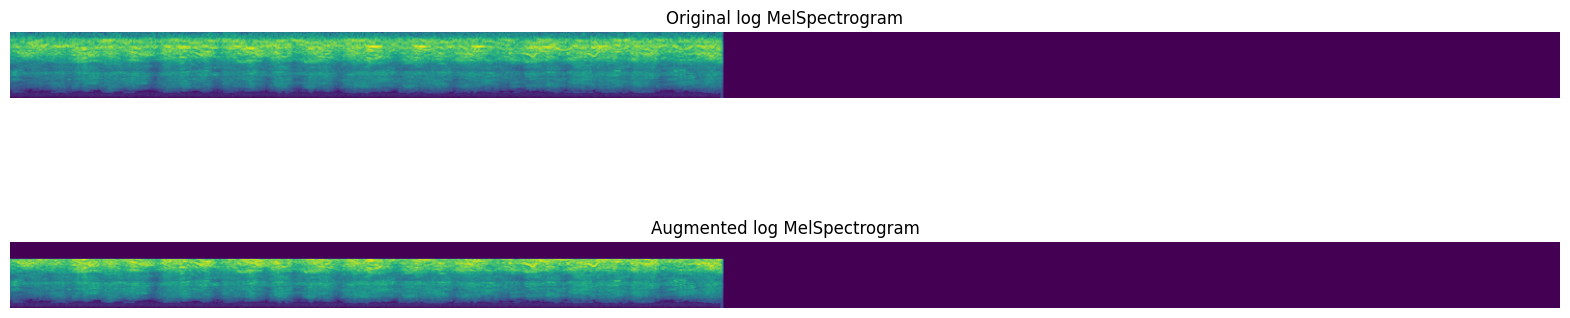

In [ ]:
spect_augmentor = SpectAugment(filling_value="mean", n_freq_masks=2, n_time_masks=5, max_freq=10, max_time=50)
spect_augmentor = SpectAugment(filling_value='min', n_freq_masks=10, n_time_masks=5, max_freq=10, max_time=50)
# применим аугментацию к данным
for batch in train_dataloader:
    break

x = batch["x"].to(device)
lens = batch["len"].to(device)
x_logmel, lens = compute_log_melspectrogram_reference(
    x, lens, sr=train_dataset.sr, device=device
)
x_logmel_augmented, lens = spect_augmentor(x_logmel, lens)


# нарисуем спектрограмму до и после аугментации
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.title("Original log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel[0].cpu().numpy())

plt.subplot(2, 1, 2)
plt.title("Augmented log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel_augmented[0].cpu().numpy())

plt.show()

In [ ]:
cnn = CNN10()
cnn.to(device)

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 4


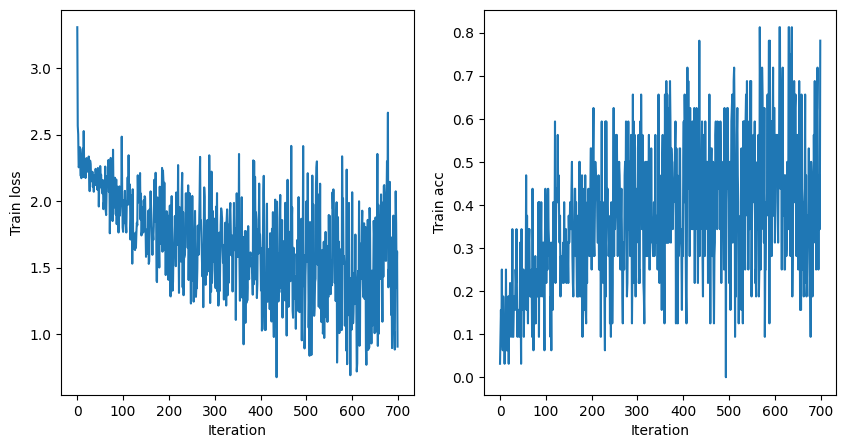

100%|██████████| 140/140 [03:51<00:00,  1.65s/it]


In [ ]:
# обучим модель на данных с аугментациями
train_audio_clfr(
    cnn,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
    augmentation=SpectAugment(),
    num_epochs=5,
)

**Задание: для получения 0.5 балла сделайте подбор параметров аугментации и добейтесь accuracy модели выше 0.9 на валидационном датасете.**

Val accuracy: 0.5358288770053476


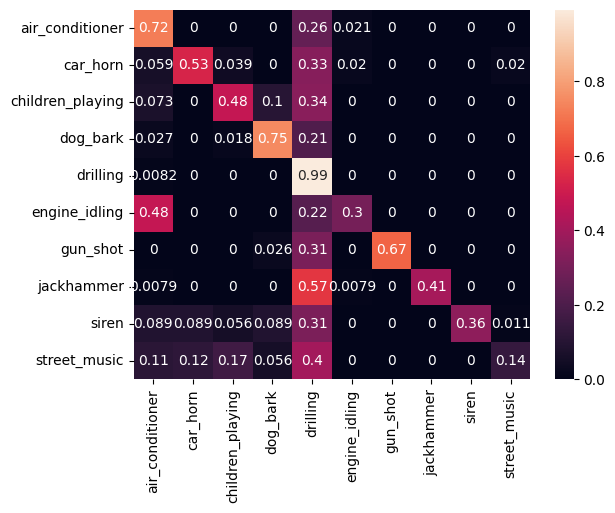

In [ ]:
plot_confusion_matrix(
    cnn,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)

In [ ]:
# да, это жестко(